### Load libs

In [1]:
import time
import numpy as np
import matplotlib.pylab as plt
from ridgeplot import ridgeplot
import pandas as pd
import random
import os

import torch
import torch
from torch.utils.data import Dataset, DataLoader

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from utils.train import *


In [2]:
# define save path
save_path = './trials/trial_exp'
if not os.path.exists(save_path):
    os.makedirs(save_path)
# define cache path
cache_path = 'cache/visualize_experiment'
if not os.path.exists(cache_path):
    os.makedirs(cache_path)


### Create data generator

In [3]:
# generate mean with multi-modal behavior
random.seed(0)
def generate_mean(off, modes, lens, betas):
    mean = np.zeros(sum(lens))
    mean[:lens[0]] = off + \
                    np.sin((2*np.pi / 3) * np.arange(0, lens[0], 1)) * betas[0, 0] + \
                    np.cos((2*np.pi / 7) * np.arange(0, lens[0], 1)) * betas[0, 1]
    state = random.randint(0, 1)
    mean[lens[0]:sum(lens)] = off + modes[state] + \
                            np.sin((2*np.pi / 3) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 0] + \
                            np.cos((2*np.pi / 7) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 1]
    
    return mean

In [4]:
# generate the covariance matrix and sample from the Gaussian distribution \
# with specified mean and covariance
lens = [5, 9]
modes = [-10, 10]
off = 0
betas = np.array([[0.5, 0.5], [0.3, 0.7], [0.7, 0.3]])

cov = np.zeros((sum(lens), sum(lens)))
row = np.array([1] + [1 / abs(i) for i in range(1, sum(lens))])
for i in range(sum(lens)):
    cov[i, :(i+1)] = np.flip(row[:(i+1)])
    cov[i, (i+1):] = row[1:(sum(lens)-i)]
np.fill_diagonal(cov, 2)

train_samples = 2000
val_samples = 100

train_data = []
val_data = []
test_data = []
for i in range(train_samples):
    if i < val_samples:
        val_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])
        test_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

    train_data.append([0,
                    np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)), 
                    np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

In [5]:
# scale the data to [0, 1] using the min and max of the training data
maxx = np.max([train_data[i][1].max() for i in range(len(train_data))])
minn = np.min([train_data[i][1].min() for i in range(len(train_data))])

train_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in train_data]

val_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in val_data]


test_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in test_data]

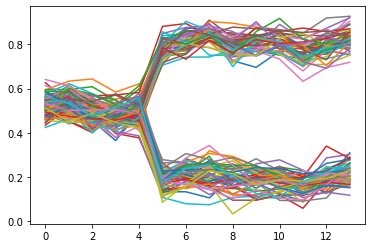

In [6]:
# plot test samples
plot_test = np.vstack([data[1].reshape((1, -1)) for data in test_data])
out = plt.plot(plot_test.transpose())
plt.show()

In [7]:
# save data
pd.DataFrame(plot_test).to_csv(f'{cache_path}/full_true_sample.csv', index=False)

### Create PyTorch data set

In [8]:
class Data(Dataset):
  def __init__(self, data, flag='train', size=None):
    # size [seq_len, label_len, pred_len]
    # info
    self.seq_len = size[0]
    self.label_len = size[1]
    self.pred_len = size[2]
    
    # init
    self.data = data
    len_segs = np.array([len(subj_seg[1]) for subj_seg in self.data])
    len_segs = len_segs - self.seq_len - self.pred_len + 1
    self.len_segs = np.insert(np.cumsum(len_segs), 0, 0)
  
  def __getitem__(self, index):

    idx_seg = np.argmax(self.len_segs > index) - 1
    seg = self.data[idx_seg]

    s_begin = index - self.len_segs[idx_seg]
    s_end = s_begin + self.seq_len
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    subj_id = seg[0]
    seq_x = seg[1][s_begin:s_end]
    seq_y = seg[1][r_begin:r_end]
    seq_x_mark = seg[2][s_begin:s_end]
    seq_y_mark = seg[2][r_begin:r_end]

    return subj_id, seq_x, seq_y, seq_x_mark, seq_y_mark
  
  def __len__(self):
    return self.len_segs[-1]

In [9]:
len_seq, len_label, len_pred = 4, 2, 2

train_data = Data(train_data, size=[len_seq, len_label, len_pred])
val_data = Data(val_data, size=[len_seq, len_label, len_pred])
test_data = Data(test_data, size=[len_seq, len_label, len_pred])

### Define model

In [10]:
device = torch.device('cuda:0')
model = Gluformer(d_model=256, 
                    n_heads=4, 
                    d_fcn=1024, 
                    r_drop=0.4, 
                    activ="relu", 
                    num_enc_layers=2, 
                    num_dec_layers=1,
                    distil=True,
                    len_seq=len_seq, 
                    len_pred=len_pred,
                    num_features=1)
model.train()
model = model.to(device)

### Train with the infinite mixture objective

In [11]:
model_path = os.path.join(cache_path, "model_inf_mixture.pth")
num_samples = 5 # number of samples for MC estimate
batch_size = 256 # batch size for optimization
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=0, 
                                drop_last=True, 
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                drop_last=False,
                                collate_fn = collate_fn_custom)


In [12]:
epochs = 100
criterion =  ExpLikeliLoss(num_samples)
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(5, 1e-6)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []
    
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id,
                                            batch_x=batch_x, 
                                            batch_y=batch_y, 
                                            batch_x_mark=batch_x_mark, 
                                            batch_y_mark=batch_y_mark, 
                                            len_pred=len_pred, 
                                            len_label=len_label, 
                                            model=model, 
                                            device=device)
        loss = criterion(pred, true, logvar)
        train_loss.append(float(loss.item()))
        
        # print every 10
        if (i+1) % 10==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            logvar = logvar.reshape(-1, num_samples)
            print(f"\t variance shape: {logvar.shape}")
            print("\t variance: ", np.exp(logvar.detach().cpu().numpy()[0, :]))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()
        
        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation / test loss + test metric
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true, logvar)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)

        test_metric, test_loss = [], []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id, 
                                    batch_x=batch_x, 
                                    batch_y=batch_y, 
                                    batch_x_mark=batch_x_mark, 
                                    batch_y_mark=batch_y_mark, 
                                    len_pred=len_pred, 
                                    len_label=len_label, 
                                    model=model, 
                                    device=device)
            loss = criterion(pred, true, logvar)
            test_loss.append(float(loss.item()))

            # compute metric: APE
            pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
            # transform back to data space
            # pred = (pred + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
            # true = (true + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
            # arrange in proper shape: take mean of predicted samples
            pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
            pred = np.mean(pred, axis=2)
            true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))[:, :, 0]
            # compute APE
            test_metric.append(np.mean(np.abs(true - pred) / true))
        test_loss = np.average(test_loss)
        test_metric = np.median(test_metric)
    
    # check early stopping
    early_stop(val_loss, model, model_path)
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)
    
    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f} | Test Loss: {2:.7f}".format(train_loss, val_loss, test_loss))
    print("Test metric: {0:.7f}".format(test_metric))

	 iters: 10 / 70, epoch: 1 | loss: -1.7722604
	 variance shape: torch.Size([256, 5])
	 variance:  [0.2498124  0.2901721  0.06826825 0.11029888 0.24554543]
	 speed: 0.0531s/iter; left time: 370.9022s
	 iters: 20 / 70, epoch: 1 | loss: -1.1644999
	 variance shape: torch.Size([256, 5])
	 variance:  [0.02259093 0.15525945 0.03696251 0.24306966 0.7302877 ]
	 speed: 0.0369s/iter; left time: 257.7886s
	 iters: 30 / 70, epoch: 1 | loss: -2.0883527
	 variance shape: torch.Size([256, 5])
	 variance:  [0.10606655 0.23991597 0.19498016 0.04884259 0.23991597]
	 speed: 0.0365s/iter; left time: 254.5108s
	 iters: 40 / 70, epoch: 1 | loss: -2.9213958
	 variance shape: torch.Size([256, 5])
	 variance:  [0.01964642 0.06466588 0.23567684 0.02861729 0.07908682]
	 speed: 0.0354s/iter; left time: 246.5458s
	 iters: 50 / 70, epoch: 1 | loss: -2.8724558
	 variance shape: torch.Size([256, 5])
	 variance:  [0.23318358 0.12605299 0.27442226 0.23318358 0.14270109]
	 speed: 0.0361s/iter; left time: 251.0334s
	 ite

### Test infinite mixture model

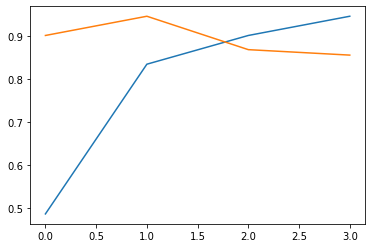

In [ ]:
# exract 1 sample for prediction
device = "cpu"
subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark = train_data.__getitem__(40)
out = plt.plot(batch_x[:, 0])
out = plt.plot(batch_y[:, 0])

# repeat input for num_samples
[subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark] = [torch.tensor(tensor).unsqueeze(0).repeat_interleave(num_samples, 0).float().to(device) 
                                                            for tensor in [subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark]]
# create decoder input
dec_inp = torch.zeros([batch_y.shape[0], len_pred, batch_y.shape[-1]]).float().to(device)
dec_inp = torch.cat([batch_y[:, :len_label, :], dec_inp], dim=1).float().to(device)

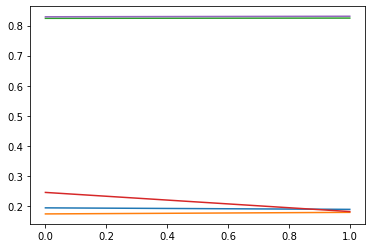

In [ ]:
# load model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.train()

# predict
pred, logvar = model(subj_id, batch_x, batch_x_mark, dec_inp, batch_y_mark)
out = plt.plot(pred[:, :, 0].permute(1, 0).detach().cpu().numpy())
plt.show()

In [ ]:
# sample from predictive
num_samples_pred = 100
pred_sample = []
pred = pred.detach().cpu().numpy()
logvar = logvar.detach().cpu().numpy()

for j in range(len_pred):
    s = []
    for i in range(num_samples):
       s += list(np.random.normal(pred[i, j, 0], np.sqrt(np.exp(logvar[i, 0, 0])), num_samples_pred))
    pred_sample.append(s)

In [ ]:
pd.DataFrame(np.matrix(pred_sample)).to_csv(f'{cache_path}/pred_sample.csv', index=False)
pd.DataFrame(batch_x[0, :, 0].numpy()).to_csv(f'{cache_path}/input.csv', index=False)
pd.DataFrame(batch_y[0, :, 0].numpy()).to_csv(f'{cache_path}/output.csv', index=False)
pd.DataFrame(pred[:, :, 0]).to_csv(f'{cache_path}/pred.csv', index=False)
pd.DataFrame(logvar[:, 0, 0]).to_csv(f'{cache_path}/pred_var.csv', index=False)